In [1]:
#################################
#
#           IMPORTS
#
#################################

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from textblob import TextBlob
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from ISLP import confusion_table
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#################################
#
#       DATA PROCESSING
#
#################################

# Define a function for sentiment analysis
def calculate_sentiment(text):
    blob = TextBlob(str(text))
    sentiment_score = blob.sentiment.polarity
    return sentiment_score

# Define a function to preprocess text data using TF-IDF vectorizer
def preprocess_text(text_data):
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    return tfidf_vectorizer.fit_transform(text_data)

def remove_keywords(column, keywords):
    for keyword in keywords:
        column = column.str.replace(keyword, '', case=False)
    return column

In [2]:
#################################
#
#          Question 1
#
#################################

random = 42

removed_cols = ['date_review', 'year']

# Load the training data
data = pd.read_csv('MLforEcon_small_training_with_quotes_FinalPC_v3.csv')

# Drop the undesired column
data = data.drop(columns=removed_cols)

# Fill missing values in 'pros' and 'cons' columns with 'unknown'
data['pros'].fillna('unknown', inplace=True)
data['cons'].fillna('unknown', inplace=True)
data['headline'].fillna('unknown', inplace=True)

# Create new features based on text length
data['pros_length'] = data['pros'].apply(len)
data['cons_length'] = data['cons'].apply(len)

# List of keywords to remove
removed_words = ['good', 'work']
# Apply the remove_keywords function to 'pros' and 'cons' columns
#data['pros'] = remove_keywords(data['pros'], removed_words)
#data['cons'] = remove_keywords(data['cons'], removed_words)

# Create new features based on text sentiment
data['headline_sentiment'] = data['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data['pros_sentiment'] = data['pros'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data['cons_sentiment'] = data['cons'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Encode categorical variables using LabelEncoder
encoder = LabelEncoder()
data['firm'] = encoder.fit_transform(data['firm'])
data['job_title'] = encoder.fit_transform(data['job_title'])
data['location'] = encoder.fit_transform(data['location'])

# TF-IDF Vectorization for text features (headline, pros, cons)
#tfidf_headline = TfidfVectorizer()
#tfidf_pros = TfidfVectorizer()
#tfidf_cons = TfidfVectorizer()

#headline_tfidf = tfidf_headline.fit_transform(data['headline'])
#pros_tfidf = tfidf_pros.fit_transform(data['pros'])
#cons_tfidf = tfidf_cons.fit_transform(data['cons'])

# Convert sparse matrices to dataframes and concatenate with original data
#headline_tfidf_df = pd.DataFrame(headline_tfidf.toarray(), columns=tfidf_headline.get_feature_names_out())
#pros_tfidf_df = pd.DataFrame(pros_tfidf.toarray(), columns=tfidf_pros.get_feature_names_out())
#cons_tfidf_df = pd.DataFrame(cons_tfidf.toarray(), columns=tfidf_cons.get_feature_names_out())

#data = pd.concat([data, headline_tfidf_df, pros_tfidf_df, cons_tfidf_df], axis=1)

# Features
features = ['headline_sentiment', 'pros_sentiment', 'cons_sentiment', 
            'pros_length', 'cons_length', 'location', 'firm', 'job_title']
#features = ['headline_sentiment', 'pros_sentiment', 'cons_sentiment', 'pros_length', 'cons_length', 'location', 'firm', 'job_title'] + list(headline_tfidf_df.columns) + list(pros_tfidf_df.columns) + list(cons_tfidf_df.columns)

# Response variable
response = ['overall_rating']

# Separate features and target variable
X = data[features]
y = data['overall_rating']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
### Random Forest Regressor model ###

# Defining default model
rf_model = RandomForestRegressor(max_depth=15, n_estimators=500, random_state=42)
best_rf_model = rf_model

# possible parameter values to test
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 15, 20]
}

check = False

if (check):
    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_rf_model = grid_search.best_estimator_
    print(grid_search.best_params_)
else:
    rf_model.fit(X_train, y_train)
    best_rf_model = rf_model

# Predict on the validation set
#y_pred = np.round(best_rf_model.predict(X_test)).astype(int)
y_pred = best_rf_model.predict(X_test)
pred_ints = np.round(y_pred).astype(int)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared on Test Set:", r2)

# Confusion Matrix as table
table = confusion_table(y_test, pred_ints)
print(table)

Mean Squared Error on Test Set: 0.7700033668578422
R-squared on Test Set: 0.37486330929854916
Truth        1    2     3     4     5
Predicted                            
1          123  412   319   193     6
2           45  340   603   531     9
3           14  267  1469  2844    67
4            3   57   992  5504   486
5            1   16   360  4082  1257


In [8]:
count1 = (y == 1).sum()
count2 = (y == 2).sum()
count3 = (y == 3).sum()
count4 = (y == 4).sum()
count5 = (y == 5).sum()
print(count1)
print(count2)
print(count3)
print(count4)
print(count5)

5338
7427
23494
35068
28673


In [4]:
# Load the training data
testData = pd.read_csv('MLforEcon_test_data_without_response_with_quotes_FinalPC_v3.csv')

# Drop the 'date_review' column
testData = testData.drop(columns=removed_cols)

# Fill missing values in 'pros' and 'cons' columns with 'unknown'
testData['pros'].fillna('unknown', inplace=True)
testData['cons'].fillna('unknown', inplace=True)
testData['headline'].fillna('unknown', inplace=True)

# Create new features based on text length
testData['pros_length'] = testData['pros'].apply(len)
testData['cons_length'] = testData['cons'].apply(len)

# Create new features based on text sentiment
testData['headline_sentiment'] = testData['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
testData['pros_sentiment'] = testData['pros'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
testData['cons_sentiment'] = testData['cons'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Encode categorical variables using LabelEncoder
testData['firm'] = encoder.fit_transform(testData['firm'])
testData['job_title'] = encoder.fit_transform(testData['job_title'])
testData['location'] = encoder.fit_transform(testData['location'])

# Separate features and blank response variable
XTest = testData[features]
#yTest = testData['overall_rating']

final_preds = best_rf_model.predict(XTest)

In [5]:
final = pd.DataFrame(final_preds)
final.to_csv("preds.csv", index=False, header=False)

In [7]:
### Neural Netowrk MLP Model ###

from sklearn.neural_network import MLPRegressor

# Initialize and train a MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_train_pred = np.clip(model.predict(X_train),1, 5)
y_test_pred = np.clip(model.predict(X_test),1,5)

# Round the predictions to the nearest integer
#rounded_predictions = np.round(predictions).astype(int)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error on Test Set (Neural Network):", mse)

mse = mean_squared_error(y_train, y_train_pred)
print("Mean Squared Error on Train Set (Neural Network):", mse)

Mean Squared Error on Test Set (Neural Network): 1.3805174495391097
Mean Squared Error on Train Set (Neural Network): 1.4002135650538192


In [ ]:
# Define preprocessing for numerical variables (if any)
numerical_preprocessor = SimpleImputer(strategy='mean')

# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', numerical_preprocessor),
    ('model', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared on Test Set:", r2)

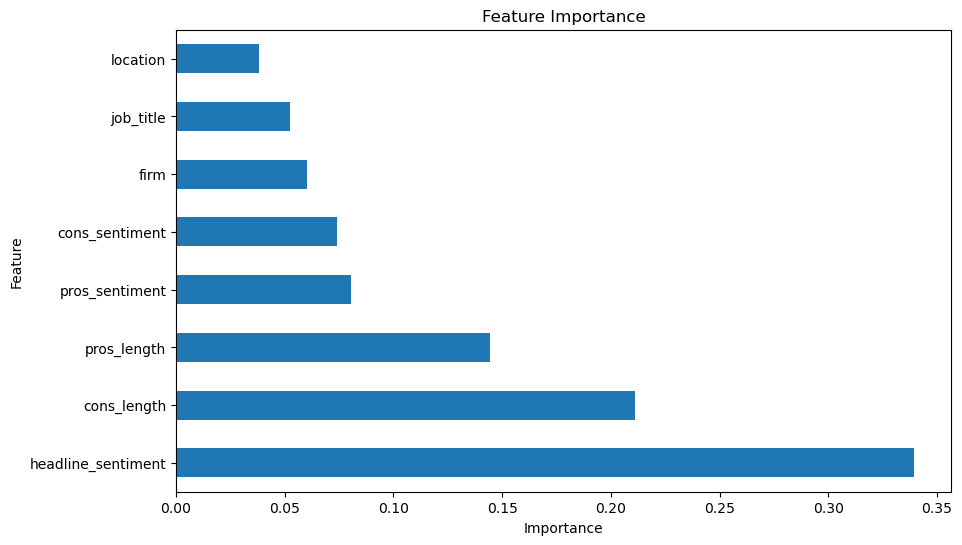

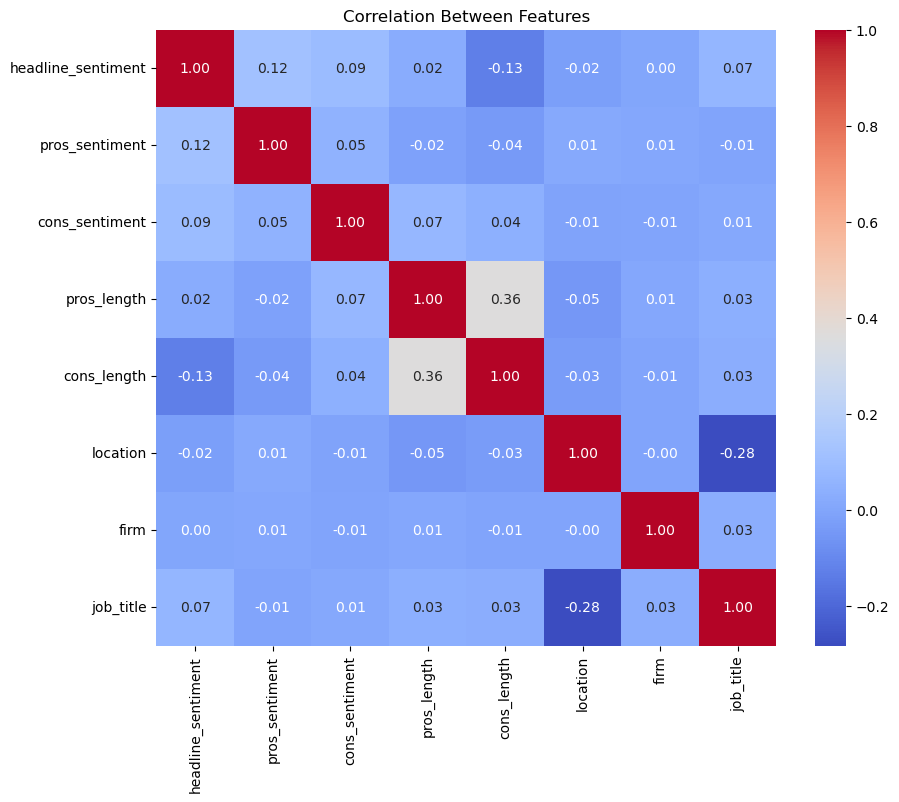

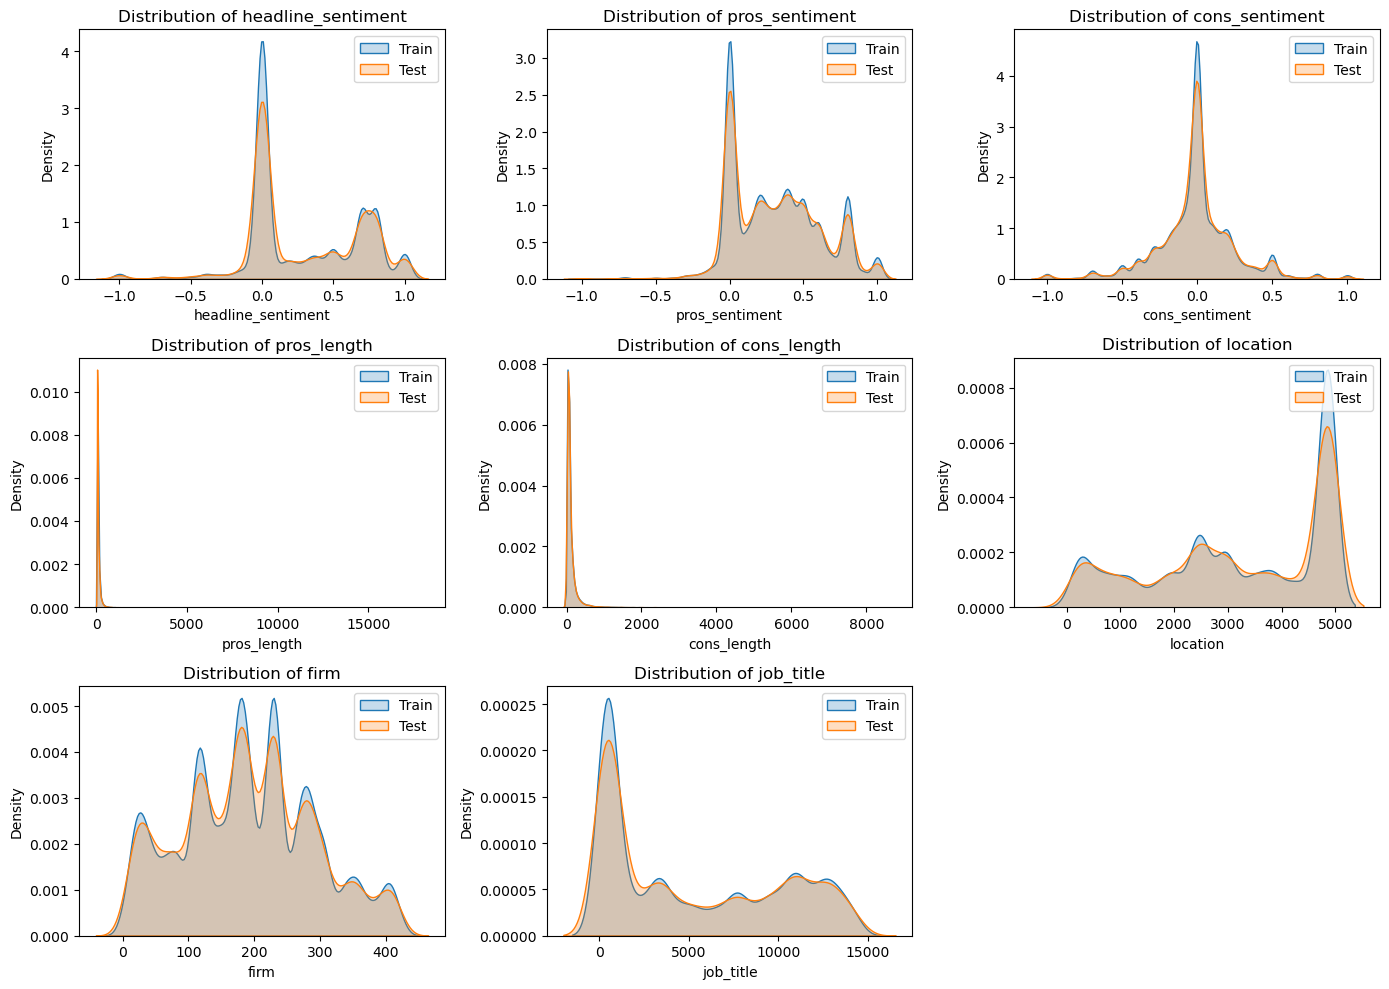

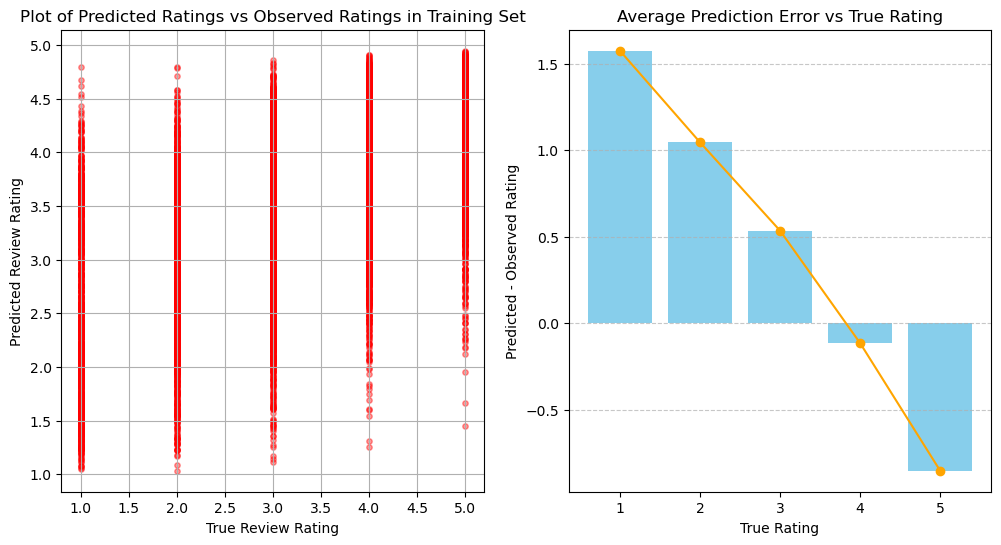

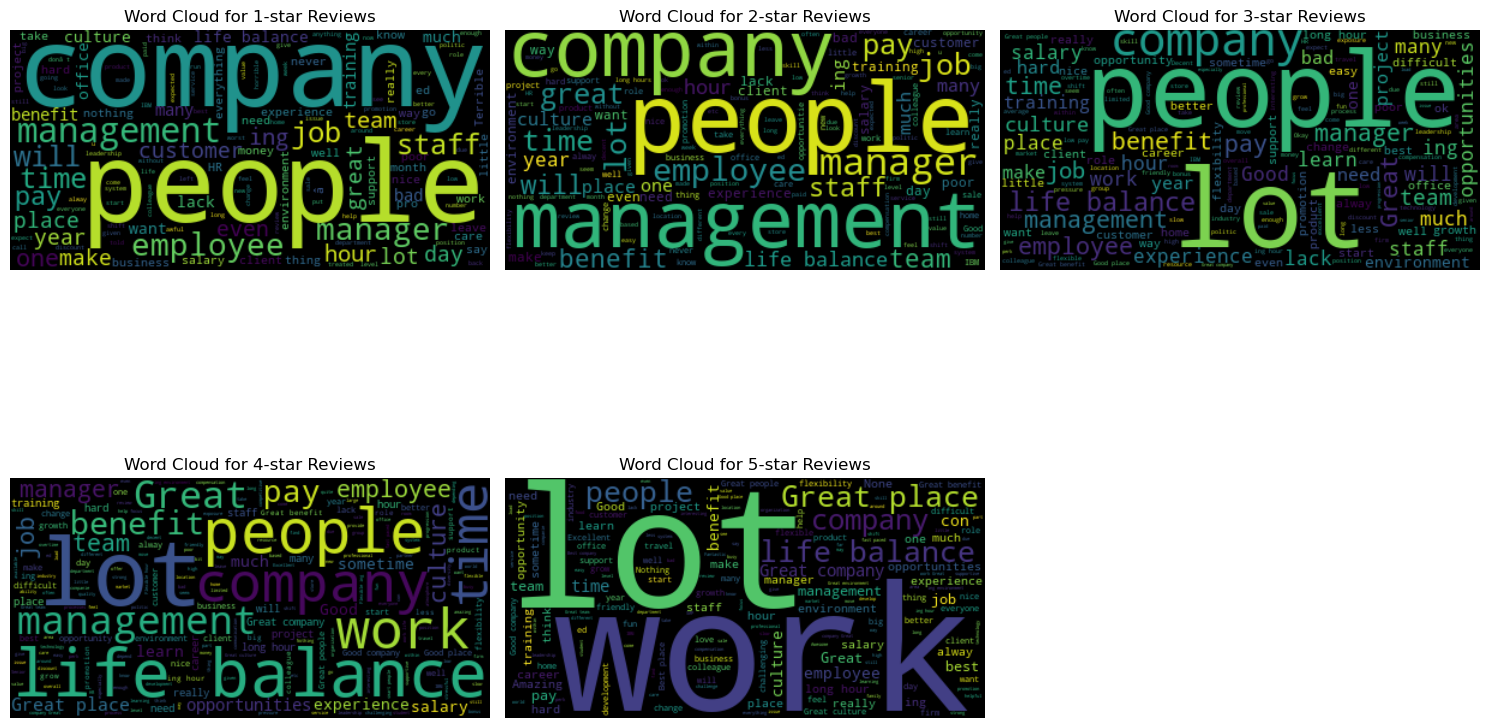

In [7]:
#################################
#
#          Question 2
#
#################################

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Importance of each feature
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(best_rf_model.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Features')
plt.show()

# Distribution of each feature in the training data vs. test data
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(X_train[feature], label='Train', fill=True)
    sns.kdeplot(X_test[feature], label='Test', fill=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
# Distribution of prediction errors
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, marker='o', s=15, alpha=0.4, color="red")
plt.grid(True)
plt.xlabel('True Review Rating')
plt.ylabel('Predicted Review Rating')
plt.title('Plot of Predicted Ratings vs Observed Ratings in Training Set')
#plt.xlim(xmin=0)
#plt.show()
# Calculate prediction error magnitudes
error_magnitudes = y_pred - y_test
# Calculate average error magnitude for each true rating value (1 to 5)
average_magnitudes = []
for rating in range(1, 6):
    mask = (y_test == rating)
    average_magnitude = np.mean(error_magnitudes[mask])
    average_magnitudes.append(average_magnitude)
# Plot histogram with trend line
plt.subplot(1,2,2)
plt.bar(range(1, 6), average_magnitudes, color='skyblue')
plt.plot(range(1, 6), average_magnitudes, marker='o', color='orange')
plt.xlabel('True Rating')
plt.ylabel('Predicted - Observed Rating')
plt.title('Average Prediction Error vs True Rating')
plt.xticks(range(1, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#errors = y_test - y_pred
#plt.figure(figsize=(8, 6))
#sns.histplot(errors, kde=True)
#plt.title('Distribution of Prediction Errors')
#plt.xlabel('Error')
#plt.ylabel('Frequency')
#plt.show()

# Words typical of each category
categories = [1, 2, 3, 4, 5]  # Assuming response variable has 5 categories

plt.figure(figsize=(15, 10))

for i, category in enumerate(categories, start=1):
    # Combine text from all three columns for the current rating category
    combined_text = data[data['overall_rating'] == category][['pros', 'cons', 'headline']].fillna('').apply(lambda x: ' '.join(x), axis=1)
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='black').generate(' '.join(combined_text))
    
    # Plot the word cloud
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}-star Reviews')
    plt.axis('off')

plt.tight_layout()
plt.show()

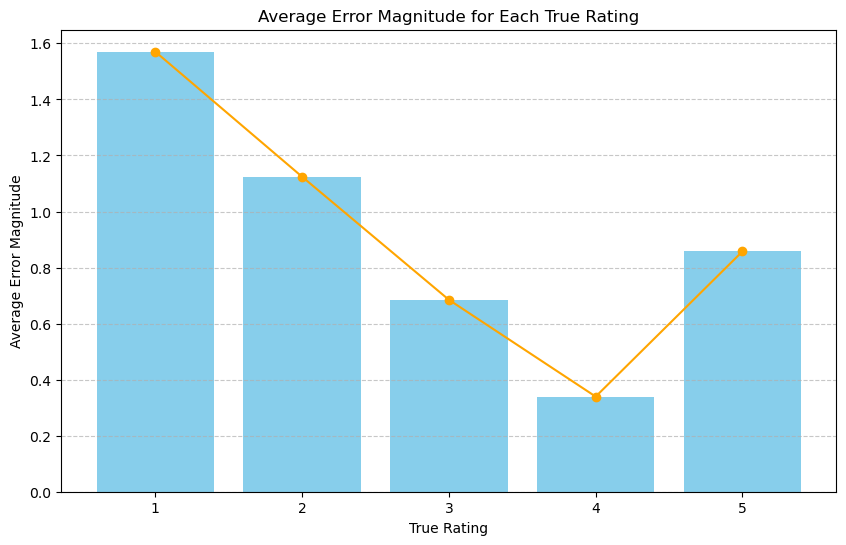

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate prediction error magnitudes
error_magnitudes = np.abs(y_pred - y_test)

# Calculate average error magnitude for each true rating value (1 to 5)
average_magnitudes = []
for rating in range(1, 6):
    mask = (y_test == rating)
    average_magnitude = np.mean(error_magnitudes[mask])
    average_magnitudes.append(average_magnitude)

# Plot histogram with trend line
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), average_magnitudes, color='skyblue')
plt.plot(range(1, 6), average_magnitudes, marker='o', color='orange')
plt.xlabel('True Rating')
plt.ylabel('Average Error Magnitude')
plt.title('Average Prediction Error Magnitude vs True Rating')
plt.xticks(range(1, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Top words per topic:
Topic 1:
good learn lot learning experience opportunities job exposure lots new
Topic 2:
work company people best employees working really culture team technology
Topic 3:
work great good benefits life balance people culture environment company
Topic 4:
good flexible working hours nice pay friendly work environment staff
Topic 5:
great training career opportunities company development people support management excellent


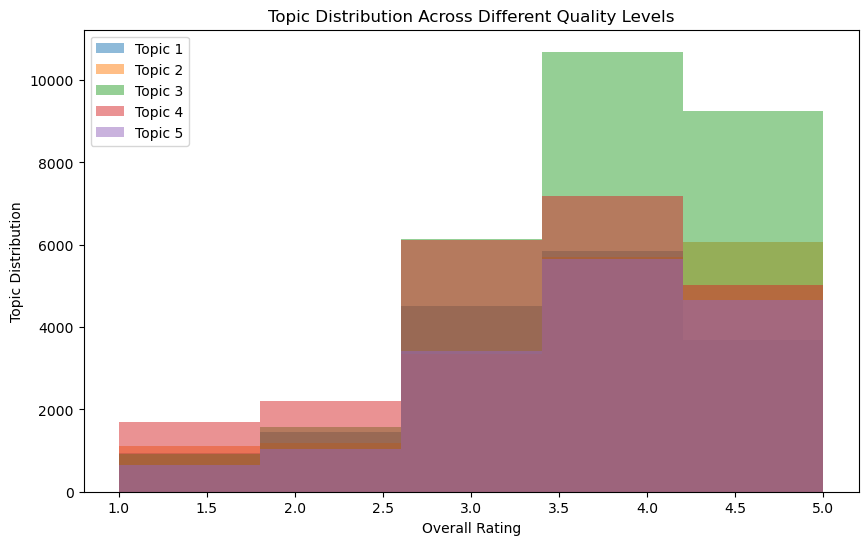

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Load the training data
data = pd.read_csv('MLforEcon_small_training_with_quotes_FinalPC_v3.csv')

# Preprocess the text data (tokenization, removing stop words, etc.)
# You can implement preprocessing steps as needed based on your analysis

# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['pros'])

# Train LDA model
num_topics = 5  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(dtm)

# Function to display topics and associated top words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10  # Number of top words to display per topic
feature_names = vectorizer.get_feature_names_out()

# Display topics and top words
print("Top words per topic:")
display_topics(lda_model, feature_names, no_top_words)

# Analyze topic distributions for different quality levels
# For example, you can group the reviews by overall_rating and analyze topic distributions within each group

# Plot topic distributions for each quality level
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(num_topics):
    topic_distribution = lda_model.transform(dtm)[:, i]
    ax.hist(data['overall_rating'], weights=topic_distribution, bins=5, alpha=0.5, label=f"Topic {i+1}")

ax.set_xlabel('Overall Rating')
ax.set_ylabel('Topic Distribution')
ax.set_title('Topic Distribution Across Different Quality Levels')
ax.legend()
plt.show()

# Interpretation and actionable insights:
# Analyze the distribution of topics across different quality levels
# Identify common themes associated with different quality levels
# Provide actionable insights for improvement based on the identified themes

[('good', 39448), ('work', 33016), ('great', 29711), ('people', 13246), ('-', 12542), ('company', 10444), ('working', 9055), ('benefits', 7760), ('opportunities', 7352), ('environment', 6413)]
[('work', 20473), ('-', 12456), ('management', 10894), ('hours', 8798), ('long', 8500), ('people', 7436), ('company', 7301), ('pay', 6999), ('working', 6763), ('time', 5925)]


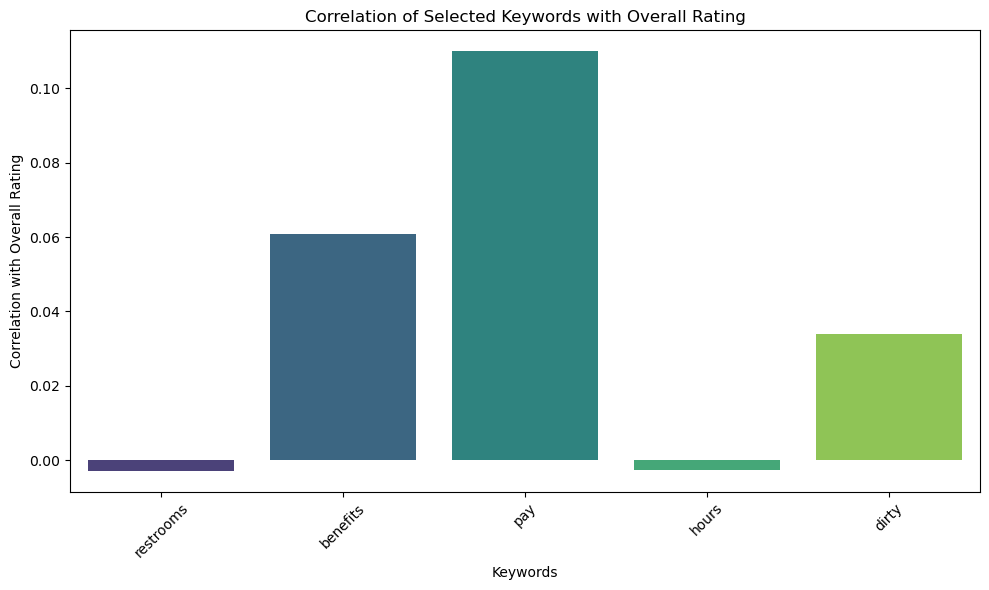

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load the training data
data = pd.read_csv('MLforEcon_small_training_with_quotes_FinalPC_v3.csv')

# Fill missing values in 'cons' column with empty string
data['cons'] = data['cons'].fillna('')

# Function to analyze word frequency in a column and return most common words after removing stop words
def analyze_word_frequency(column, top_n=10):
    stop_words = ENGLISH_STOP_WORDS
    words = ' '.join(column.dropna()).lower().split()
    words = [word for word in words if word not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Analyze word frequency in 'pros' and 'cons' columns after removing stop words
pros_word_frequency = analyze_word_frequency(data['pros'])
cons_word_frequency = analyze_word_frequency(data['cons'])

print(pros_word_frequency)
print(cons_word_frequency)

# Calculate the frequency of selected keywords in 'pros' and 'cons' columns
keywords = ['restrooms', 'benefits', 'pay', 'hours', 'dirty']

for keyword in keywords:
    data[keyword + '_in_pros'] = data['pros'].str.lower().str.contains(keyword).astype(int)
    data[keyword + '_in_cons'] = data['cons'].str.lower().str.contains(keyword).astype(int)

# Calculate correlation with overall rating
correlation_df = pd.DataFrame(index=keywords, columns=['Correlation_with_rating'])

for keyword in keywords:
    correlation_df.loc[keyword, 'Correlation_with_rating'] = data['overall_rating'].corr(data[keyword + '_in_pros']) - data['overall_rating'].corr(data[keyword + '_in_cons'])

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_df.index, y='Correlation_with_rating', data=correlation_df, palette='viridis')
plt.title('Correlation of Selected Keywords with Overall Rating')
plt.xlabel('Keywords')
plt.ylabel('Correlation with Overall Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Counter({'benefits': 9087, 'pay': 9044, 'hours': 4136, 'dirty': 11, 'restrooms': 7})
Counter({'pay': 12340, 'hours': 9366, 'benefits': 1908, 'dirty': 189, 'restrooms': 52})


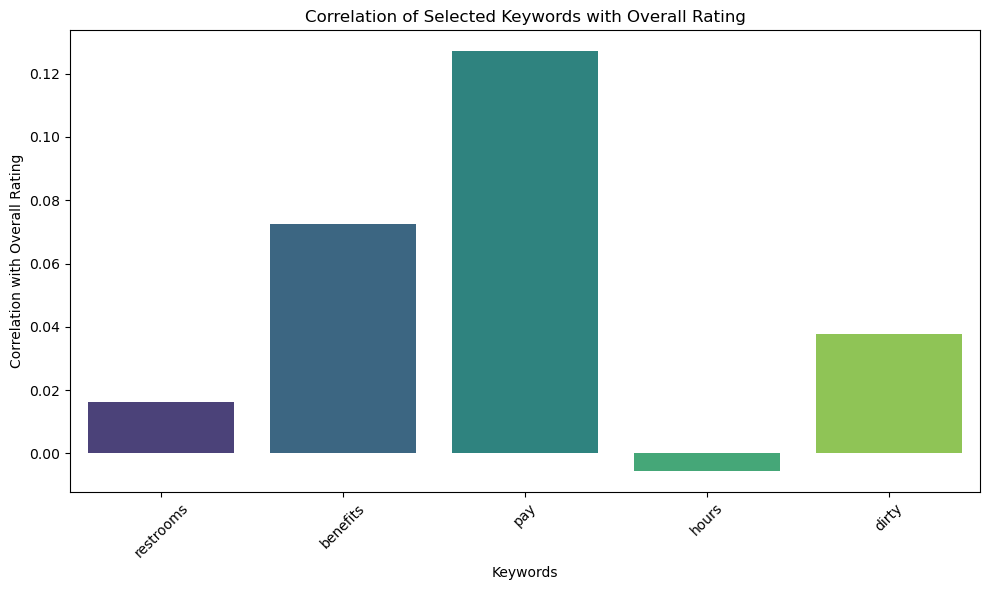

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load the training data
data = pd.read_csv('MLforEcon_small_training_with_quotes_FinalPC_v3.csv')

# Fill missing values in 'cons' column with empty string
data['cons'] = data['cons'].fillna('')

# Function to analyze word frequency in a column and return most common words after removing stop words
def analyze_word_frequency(column, top_n=10):
    stop_words = ENGLISH_STOP_WORDS
    words = ' '.join(column.dropna()).lower().split()
    words = [word for word in words if word not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Define keywords and their synonyms
keywords_and_synonyms = {
    'restrooms': ['restrooms', 'restroom', 'bathrooms', 'bathroom'],
    'benefits': ['benefits', 'perks', 'advantages', 'benefit'],
    'pay': ['pay', 'salary', 'compensation', 'wage'],
    'hours': ['hours', 'schedule', 'shifts'],
    'dirty': ['dirty', 'unclean', 'filthy', 'messy']
}

# Analyze word frequency in 'pros' and 'cons' columns after removing stop words
def analyze_keyword_frequency(column, keywords_and_synonyms):
    stop_words = ENGLISH_STOP_WORDS
    keyword_counts = Counter()
    for text in column.dropna():
        words = text.lower().split()
        words = [word for word in words if word not in stop_words]
        for keyword, synonyms in keywords_and_synonyms.items():
            if any(synonym in words for synonym in synonyms):
                keyword_counts[keyword] += 1
    return keyword_counts

# Calculate the frequency of selected keywords in 'pros' and 'cons' columns
pros_keyword_frequency = analyze_keyword_frequency(data['pros'], keywords_and_synonyms)
cons_keyword_frequency = analyze_keyword_frequency(data['cons'], keywords_and_synonyms)

print(pros_keyword_frequency)
print(cons_keyword_frequency)

# Calculate correlation with overall rating
correlation_df = pd.DataFrame(index=keywords_and_synonyms.keys(), columns=['Correlation_with_rating'])

for keyword in keywords_and_synonyms.keys():
    pros_keyword_in_text = data['pros'].str.lower().apply(lambda x: any(synonym in x for synonym in keywords_and_synonyms[keyword])).astype(int)
    cons_keyword_in_text = data['cons'].str.lower().apply(lambda x: any(synonym in x for synonym in keywords_and_synonyms[keyword])).astype(int)
    correlation_df.loc[keyword, 'Correlation_with_rating'] = data['overall_rating'].corr(pros_keyword_in_text) - data['overall_rating'].corr(cons_keyword_in_text)

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_df.index, y='Correlation_with_rating', data=correlation_df, palette='viridis')
plt.title('Correlation of Selected Keywords with Overall Rating')
plt.xlabel('Keywords')
plt.ylabel('Correlation with Overall Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


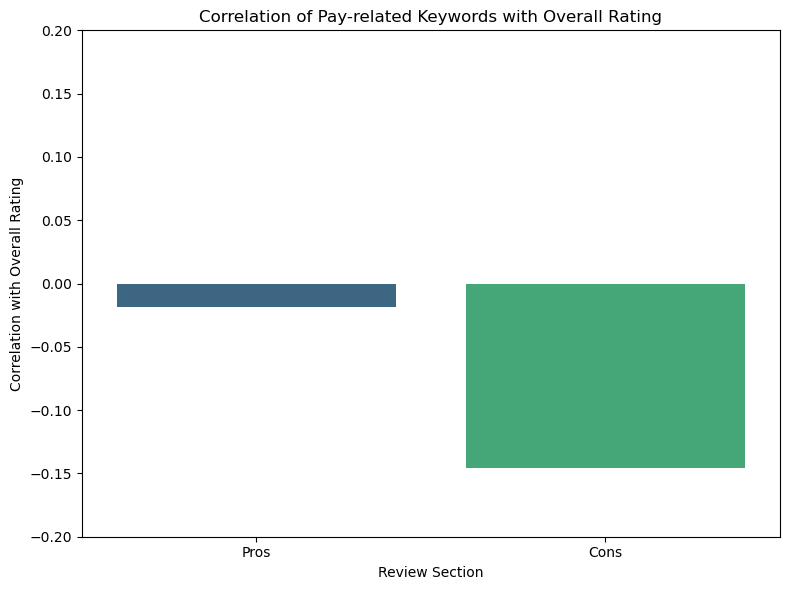

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the training data
data = pd.read_csv('MLforEcon_small_training_with_quotes_FinalPC_v3.csv')
data['cons'] = data['cons'].fillna('')

# Define keywords related to pay
pay_keywords = ['pay', 'salary', 'wage', 'compensation', 'income']

# Function to check the presence of pay-related keywords in text
def check_keyword_presence(text):
    text_lower = text.lower()
    for keyword in pay_keywords:
        if keyword in text_lower:
            return True
    return False

# Apply the function to 'pros' and 'cons' columns to check presence of pay-related keywords
data['pay_in_pros'] = data['pros'].apply(check_keyword_presence).astype(int)
data['pay_in_cons'] = data['cons'].apply(check_keyword_presence).astype(int)

# Calculate correlation with overall rating
correlation_with_pros = data['overall_rating'].corr(data['pay_in_pros'])
correlation_with_cons = data['overall_rating'].corr(data['pay_in_cons'])

# Plot the correlation
plt.figure(figsize=(8, 6))
sns.barplot(x=['Pros', 'Cons'], y=[correlation_with_pros, correlation_with_cons], palette='viridis')
plt.title('Correlation of Pay-related Keywords with Overall Rating')
plt.xlabel('Review Section')
plt.ylabel('Correlation with Overall Rating')
plt.ylim(-0.2, 0.2)  # Limit the y-axis to focus on subtle differences
plt.tight_layout()
plt.show()
